## HydroSOS - Persistence and Hydrological Analogues method

In this notebook, we explore the Persistance and Hydrological Analogue method
Firts, we import the python libraries

In [1]:
%reset -f

In [2]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

We create function for percentile definition

In [3]:
# Quantile Function Definitions
def q1(x):
    return x.quantile(0.28)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.72)

def q5(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

def q87(x):
    return x.quantile(0.87)

def q13(x):
    return x.quantile(0.13)


We import the monthly discharge data from Fray Marcos station

In [4]:
DISCHARGE_DAILY = pd.read_csv('../data/fraymarcos_caudales.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Identify the missing data
DISCHARGE_DAILY_date_missing = pd.date_range(start = '1980-01-01', end = '2023-01-08',freq='D')
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
DISCHARGE_DAILY.index.name = 'Fecha' # Set index Fecha
DISCHARGE_DAILY.columns = ['Station','Discharge']
DISCHARGE_DAILY = DISCHARGE_DAILY.drop(columns='Station')
HTML(DISCHARGE_DAILY.head(6).to_html())

,Discharge
Fecha,
1980-01-01,7.906
1980-01-02,7.978
1980-01-03,7.978
1980-01-04,7.978
1980-01-05,7.978
1980-01-06,7.978


### Plot the results

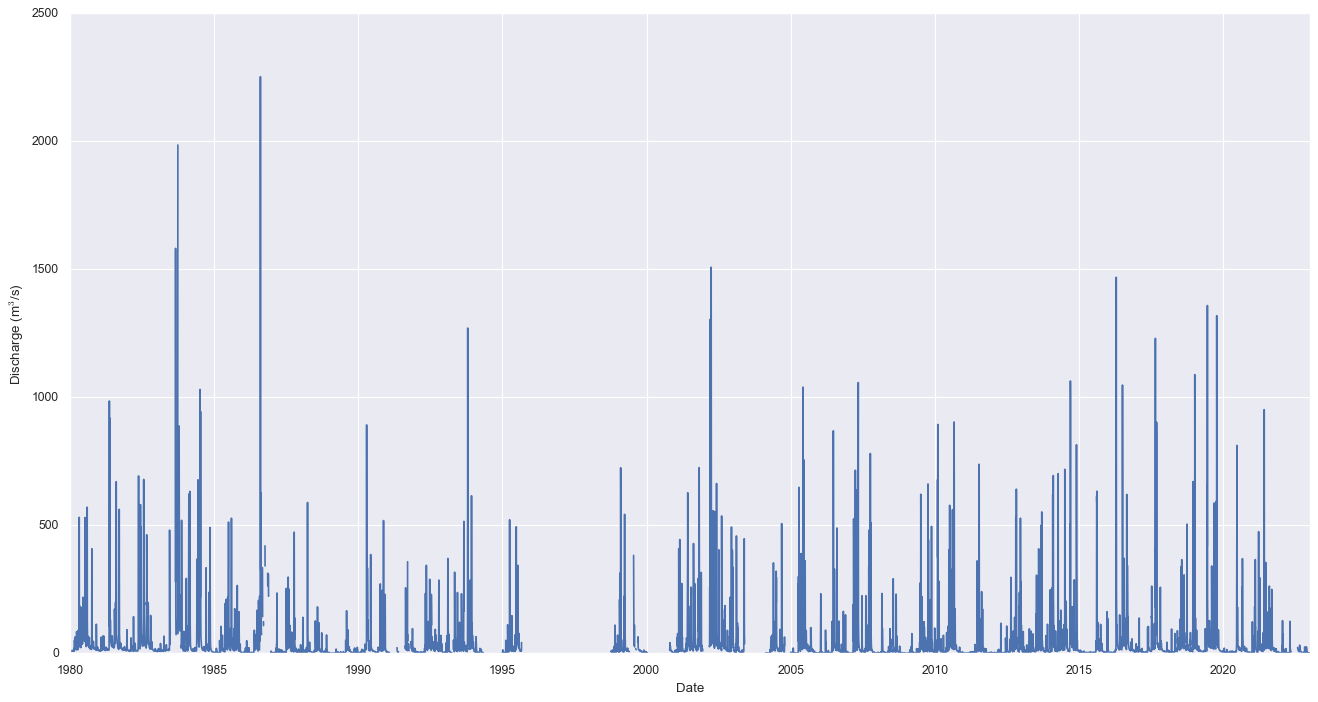

In [5]:
ax1 = DISCHARGE_DAILY['Discharge'].plot(figsize=(20, 10));
ax1.set_xlabel('Date');
ax1.set_ylabel('Discharge (m$^3$/s)');

## Calculate monthly mean from daily data

First, we identify the months which contains lower that 5 null value observation.

In [6]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()).unstack(1)
# sum the number of null values and assing a "true" if the number of null values are lower that a number for a given month
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()).unstack(1) < 5
BOOL_MISSING = BOOL_MISSING.to_frame() # convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

NUMBER_MISSING = NUMBER_MISSING.to_frame()
NUMBER_MISSING.columns = ['number_missing'] # change the column name to "missing"

# BOOL_MISSING[~BOOL_MISSING['missing']] # print the dates that does not fulfill the criterion of null data in for each month

# NUMBER_MISSING.to_csv('number_missing.txt') # if you want to export the file as csv

# NUMBER_MISSING.to_clipboard()

After this, we calculate the monthly mean flow only if the null values in that month are below 5 values

In [7]:
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M').apply(lambda x: x.mean() if x.isnull().sum() < 5 else np.nan)
DISCHARGE_MONTHLY['Year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['Month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month < 4, DISCHARGE_MONTHLY.index.year + 1)

## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['Year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['Month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['Day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month < 4, DISCHARGE_DAILY.index.year + 1)
## 
HTML(DISCHARGE_MONTHLY.head(18).to_html(index=False))
DISCHARGE_MONTHLY.to_clipboard()

## Select by Climatology range

First, we transform the discharge to a logaritmic scale and we insert it in the dataframe

In [8]:
DISCHARGE_MONTHLY['Q_to_log'] = np.log(DISCHARGE_MONTHLY['Discharge'])

In [9]:
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=False))

Discharge,Year,Month,water_year,Q_to_log
11.981414,2022,8,2023,2.483357
7.823533,2022,9,2023,2.057136
3.412581,2022,10,2023,1.227469
8.174467,2022,11,2023,2.101015
2.383414,2022,12,2023,0.868534
1.210500,2023,1,2023,0.191033


we plot a Histogram that show the Discharge distribution after the log-transformation

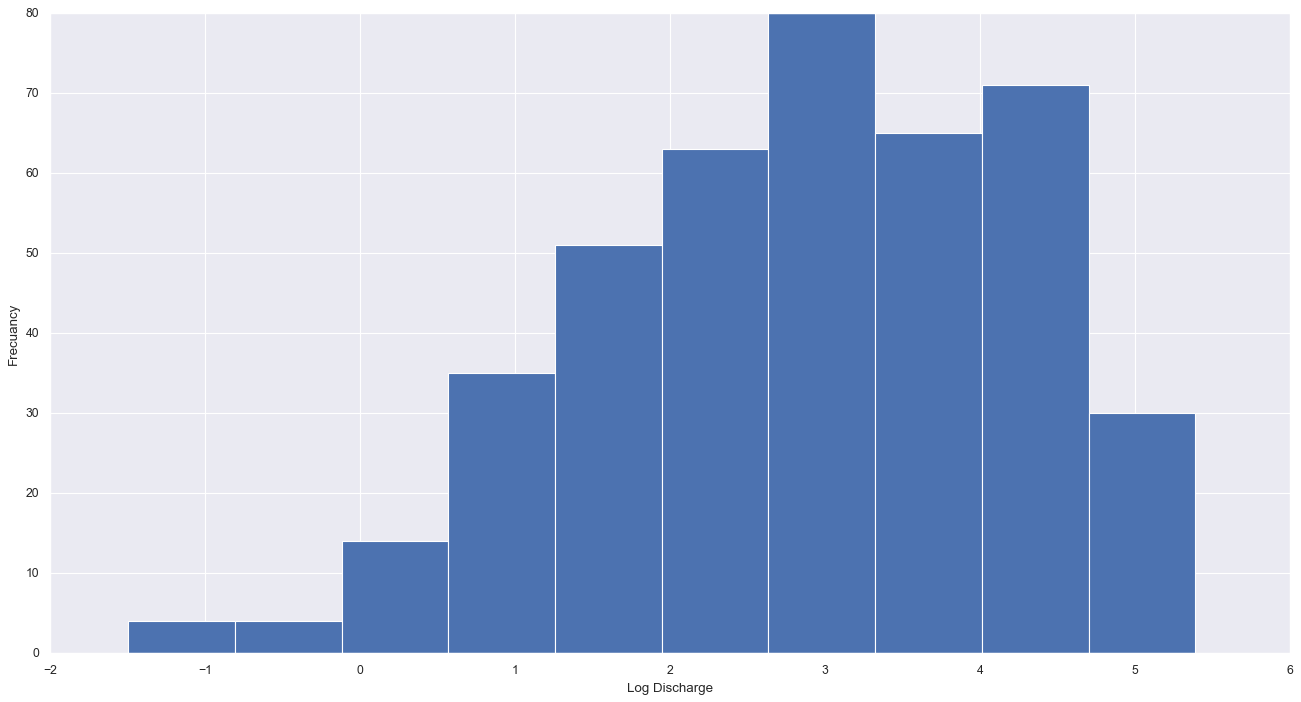

In [10]:
ax2 = DISCHARGE_MONTHLY['Q_to_log'].hist(figsize=(20, 10));
# ax2.set_xlim(-3.0,3.0)
ax2.set_xlabel('Log Discharge');
ax2.set_ylabel('Frecuancy');

In this part we select the reference period for analysis. In this case we use the 1991-2020 period

In [11]:
# DISCHARGE_MONTHLY_SELECTED = DISCHARGE_MONTHLY
DISCHARGE_MONTHLY_SELECTED = DISCHARGE_MONTHLY.loc['1980-01-01':'2023-02-01'] # Recent INUMET reference period
HTML(DISCHARGE_MONTHLY_SELECTED.tail(6).to_html(index=False))

Discharge,Year,Month,water_year,Q_to_log
11.981414,2022,8,2023,2.483357
7.823533,2022,9,2023,2.057136
3.412581,2022,10,2023,1.227469
8.174467,2022,11,2023,2.101015
2.383414,2022,12,2023,0.868534
1.210500,2023,1,2023,0.191033


Extract the years from the monthly discharge dataframe

In [12]:
YEAR_SELECTED = np.unique(DISCHARGE_MONTHLY_SELECTED['Year'])
display(YEAR_SELECTED)

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype=int64)

Plot the monthly log Discharge in a BoxPlot Graph

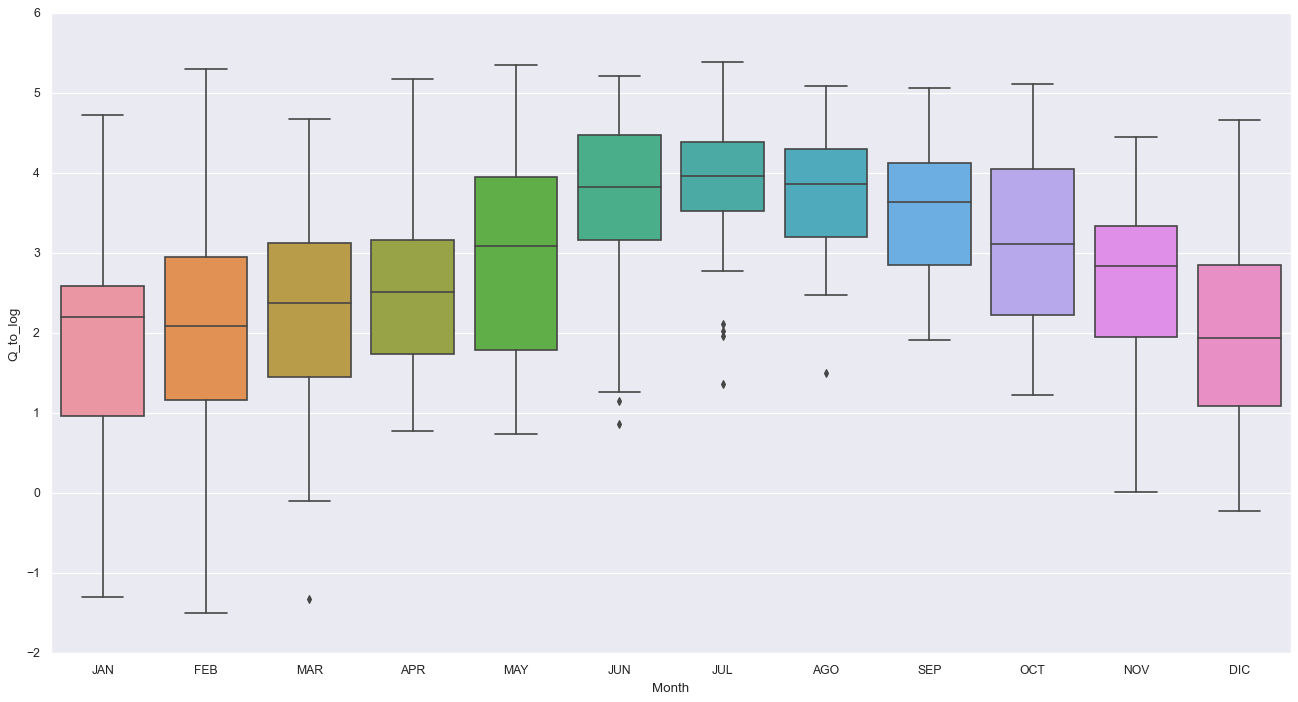

In [13]:
ax3 = plt.figure(figsize=(20, 10))
ax3 = sns.boxplot(data = DISCHARGE_MONTHLY_SELECTED, x='Month', y='Q_to_log');
ax3.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);

## Calculate Monthly statistics

In this part we calculate monthly statistcs for the QLog Variable. The statistis include: mean, min, max,25 pct, 50 pct, 75 pct

In [14]:
DISCHARGE_MONTHLY_STATS = DISCHARGE_MONTHLY_SELECTED.Q_to_log.groupby(DISCHARGE_MONTHLY_SELECTED.index.month).agg([np.min, q1, q2, np.mean, q3, np.max, np.std, q95, q5, q87, q13])
# Display results
HTML(DISCHARGE_MONTHLY_STATS.to_html())

,amin,q1,q2,mean,q3,amax,std,q95,q5,q87,q13
Fecha,,,,,,,,,,,
1,-1.290750,1.046466,2.209093,1.816728,2.527604,4.731068,1.403367,3.614124,-0.453201,3.127862,0.139931
2,-1.497226,1.220797,2.094013,2.241336,2.834962,5.301624,1.645925,5.230404,-0.059804,4.310156,0.623355
3,-1.324138,1.538069,2.384297,2.330038,2.998487,4.682407,1.275285,4.101348,0.394365,3.785092,1.130550
4,0.776063,1.837815,2.517543,2.625081,2.881443,5.181330,1.299243,4.907254,0.899154,4.425690,1.086245
5,0.738968,2.121641,3.094483,2.956500,3.890605,5.349930,1.235505,4.697518,0.874192,4.259049,1.424871
6,0.865432,3.177168,3.826904,3.613409,4.442261,5.212272,1.173055,5.044288,1.219486,4.828691,2.262110
7,1.370091,3.713525,3.962580,3.818021,4.317981,5.387990,0.896575,4.842631,2.005821,4.554441,2.854860
8,1.500976,3.242027,3.863568,3.709396,4.297419,5.094999,0.803961,4.773043,2.506998,4.428530,2.757091
9,1.914149,2.916117,3.639343,3.543018,4.010039,5.072685,0.851082,4.982383,2.256204,4.411863,2.668846


We plot the median, 28th and 72th percentile

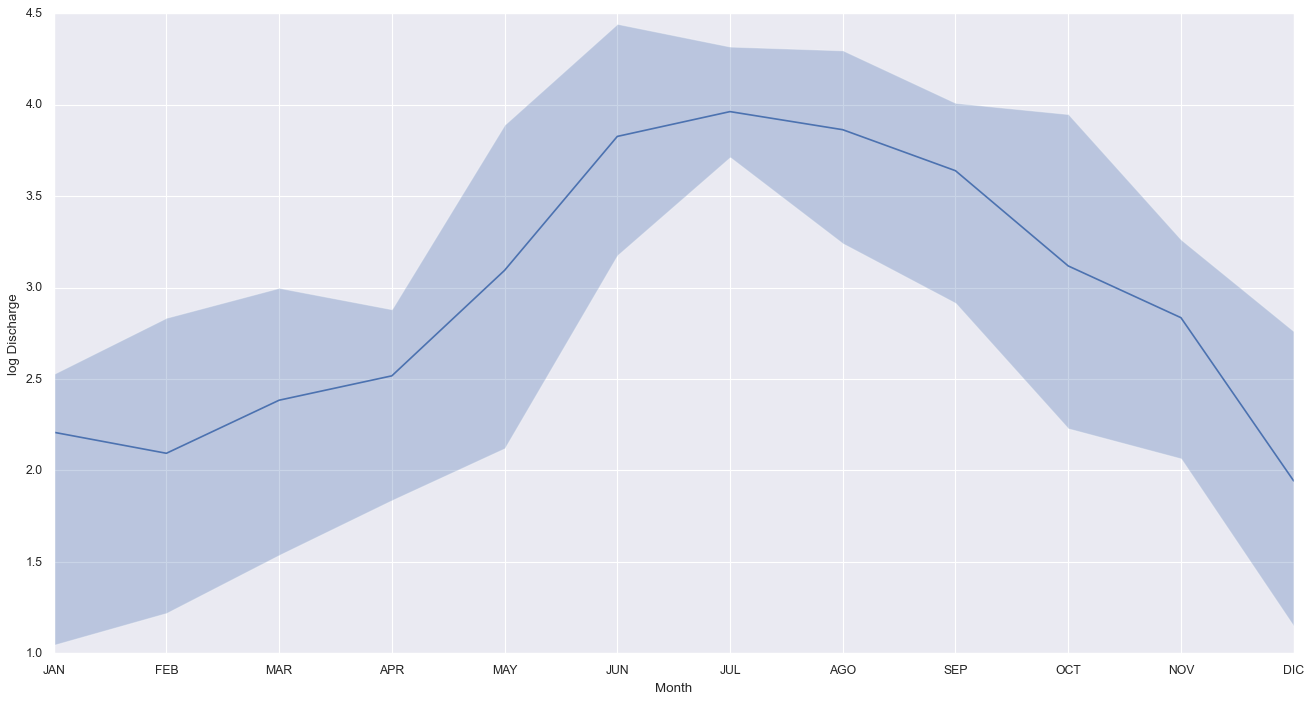

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(DISCHARGE_MONTHLY_STATS.index,DISCHARGE_MONTHLY_STATS['q2'], '-')
# plt.fill_between(monthly_sst.index, monthly_sst['q2'] + monthly_sst['std'], monthly_sst['q2'] - monthly_sst['std'],alpha=0.3)
plt.fill_between(DISCHARGE_MONTHLY_STATS.index, DISCHARGE_MONTHLY_STATS['q1'], DISCHARGE_MONTHLY_STATS['q3'],alpha=0.3)
plt.xlim(1,12)
plt.xticks(DISCHARGE_MONTHLY_STATS.index,labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);
plt.xlabel('Month');
plt.ylabel('log Discharge');

## Calculate Daily statistics

We reproduce the same procedure for the Daily dataframe

In [16]:
DISCHARGE_DAILY_STATS = DISCHARGE_DAILY.Discharge.groupby(DISCHARGE_DAILY.monthday).agg([np.min, q1, q2, np.mean, q3, np.max, np.std, q5, q95, q87, q13])
HTML(DISCHARGE_DAILY_STATS.head(12).to_html())

,amin,q1,q2,mean,q3,amax,std,q5,q95,q87,q13
monthday,,,,,,,,,,,
1,0.296,1.65724,3.3790,16.767359,11.16840,167.914,34.185302,0.60470,95.09320,28.11858,1.35522
2,0.287,1.72040,4.1410,11.022897,11.25216,101.886,19.276825,0.60070,32.83430,15.35908,1.26286
3,0.247,1.71036,3.8550,13.133154,10.79568,160.855,27.889588,0.59440,50.83910,18.26842,1.18268
4,0.204,1.71052,4.4000,18.246282,9.81056,248.637,49.464161,0.59640,48.59060,18.86206,1.07826
5,0.182,1.82704,5.0880,9.622410,10.08852,78.540,14.555780,0.52900,27.71460,17.70086,1.11074
6,0.161,1.73392,5.4560,7.260205,9.71768,38.359,7.659597,0.32150,19.30120,13.19506,1.06428
7,0.157,1.76220,5.8010,15.206051,10.19924,220.998,39.221107,0.28320,41.37950,15.95276,1.02642
8,0.167,1.48240,5.5120,39.763282,8.26908,1088.709,176.728067,0.63060,46.86330,12.89914,0.95080
9,0.162,2.12920,4.8530,25.426763,8.20200,593.058,98.872818,0.66655,40.97410,11.23666,1.02034


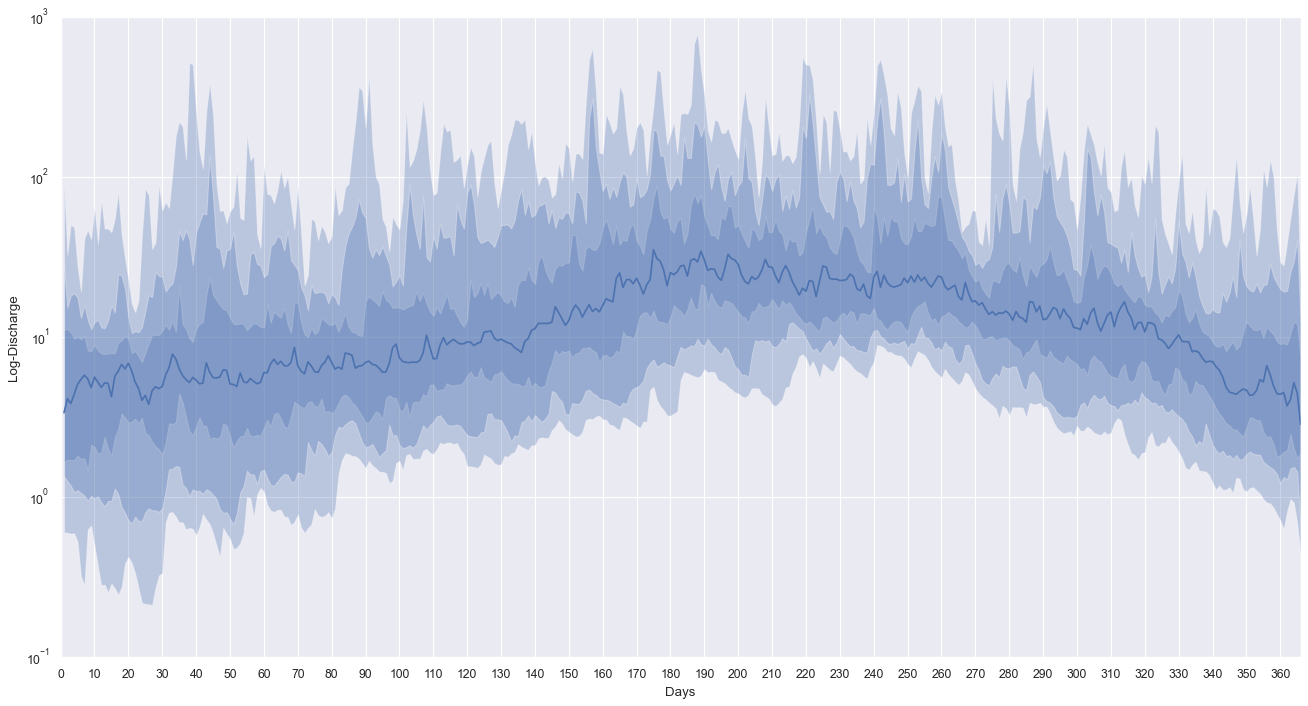

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(DISCHARGE_DAILY_STATS.index,DISCHARGE_DAILY_STATS['q2'], '-')
# plt.fill_between(monthly_sst.index, monthly_sst['q2'] + monthly_sst['std'], monthly_sst['q2'] - monthly_sst['std'],alpha=0.3)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q5'], DISCHARGE_DAILY_STATS['q95'],alpha=0.3)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q1'], DISCHARGE_DAILY_STATS['q3'],alpha=0.3)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q13'], DISCHARGE_DAILY_STATS['q87'],alpha=0.3)
plt.xlim(1,366)
plt.xticks(np.arange(0, 366, 10.0))
plt.yscale('log')
# plt.xticks(monthly_sst.index,labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);
plt.xlabel('Days');
plt.ylabel('Log-Discharge');

We re-shape the monthly log discharge dataframe using a pivot table for the Discharge (pivQ) and the log Discharge (pivLogQ)

In [18]:
DISCHARGE_MONTHLY_PIVOT = pd.pivot_table(DISCHARGE_MONTHLY_SELECTED, index=['Month'],columns=['Year'], values=['Discharge'],dropna=False)

In [19]:
DISCHARGE_MONTHLY_PIVOT.columns = YEAR_SELECTED
HTML(DISCHARGE_MONTHLY_PIVOT.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.646161,13.581484,9.905548,10.620677,32.405355,5.157516,2.771871,1.715871,19.493484,0.285581,2.569323,2.987290,3.539774,7.706581,12.525419,4.259419,NaN,NaN,NaN,23.307645,NaN,11.126290,NaN,19.319710,NaN,0.857742,27.166032,0.731968,1.815419,0.275065,9.810452,0.925032,1.271903,22.713387,80.130742,7.187774,10.201323,10.289355,9.593355,113.416677,7.294806,12.520000,19.302226,1.2105
2,14.756828,23.089821,16.765714,12.195714,200.662414,3.231786,8.138107,3.430607,7.129690,0.223750,8.777679,NaN,2.786034,59.324393,12.246679,10.087429,NaN,NaN,NaN,103.529679,NaN,77.122500,NaN,58.154536,NaN,2.469571,1.523286,0.603143,8.096793,2.201250,183.870750,1.092857,1.245690,7.085250,196.156964,3.999679,3.228931,18.128107,6.298929,16.566393,5.897069,72.336143,4.490714,NaN
3,30.993548,21.982065,19.600452,9.254645,30.611000,17.838548,3.868742,25.821806,71.751806,2.601226,10.161742,NaN,2.700935,NaN,6.826581,17.485000,NaN,NaN,NaN,55.484710,NaN,55.668645,NaN,14.947484,0.914258,0.266032,10.054613,108.029806,36.455000,12.315387,15.102935,1.743161,3.755677,6.760742,15.797903,3.848871,3.464613,6.743065,11.587935,9.119387,4.403387,57.057484,4.720871,NaN
4,68.594033,15.757933,13.647233,15.190633,12.398100,23.754033,2.232867,6.254233,17.661867,2.517133,131.210933,NaN,17.855567,NaN,5.691967,74.305633,NaN,NaN,NaN,17.519067,NaN,9.607900,152.786900,6.716767,9.695200,116.669367,3.091967,107.273900,2.949133,2.172900,10.439567,2.969733,7.834867,15.802400,70.689033,2.945333,177.919233,4.619933,6.620800,6.946400,5.099067,41.835933,13.998133,NaN
5,53.190742,210.593452,81.599839,14.660452,62.943000,28.678323,24.352323,4.686774,5.805774,2.445032,35.310968,NaN,59.820355,54.174000,NaN,20.622323,NaN,NaN,NaN,9.461536,NaN,15.505516,105.349032,51.440714,48.334645,106.835774,2.258258,118.652000,5.819097,3.590742,9.039419,6.060710,2.093774,24.564871,39.996387,3.547710,29.313129,23.631774,14.134710,18.586613,5.584000,19.378258,NaN,NaN
6,88.343367,36.137167,124.398400,NaN,139.929133,71.524667,44.253300,3.170967,5.566167,2.376033,45.920133,NaN,75.989467,49.293167,NaN,58.967733,NaN,NaN,NaN,NaN,NaN,126.796233,92.933967,NaN,39.083533,183.510500,102.458667,29.226500,19.289833,23.988667,53.430100,55.481933,13.423133,9.087500,28.745133,3.536433,23.742133,12.832233,32.404567,181.094033,84.828967,125.171067,NaN,NaN
7,80.379290,57.890613,103.427645,NaN,218.763226,58.263806,46.602258,66.730968,25.814355,7.651516,8.316742,NaN,51.935571,31.755129,NaN,92.980677,NaN,NaN,NaN,NaN,NaN,52.592839,58.753484,NaN,50.609226,50.782645,46.046548,7.114935,33.761161,85.168710,105.705774,74.822226,16.109645,55.764774,95.453613,3.935710,166.598548,47.444903,91.591000,41.316065,34.059290,53.535548,NaN,NaN
8,70.239710,118.505645,84.750613,NaN,15.231065,66.974677,NaN,52.523871,38.537935,38.986032,4.486065,NaN,20.330516,73.863000,NaN,12.673581,NaN,NaN,NaN,NaN,NaN,64.791839,90.207710,NaN,18.808355,12.462935,57.918484,31.068290,25.629419,24.554484,74.939065,45.585323,53.255000,74.167484,19.212742,118.127516,79.029161,163.203677,73.495129,47.635032,30.170645,38.622258,11.981414,NaN
9,21.893533,64.170633,61.238333,NaN,41.675833,40.407467,NaN,20.373367,14.396633,11.235500,12.195800,NaN,35.861733,32.360926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.419767,46.817700,NaN,52.496767,25.478933,17.730167,82.609833,15.313433,18.827900,151.025733,6.781167,16.513800,122.502300,159.602233,16.427500,76.599433,141.697100,29.346767,66.525500,49.964833,50.809467,7.823533,NaN


In [20]:
LOG_DISCHARGE_MONTHLY_PIVOT = pd.pivot_table(DISCHARGE_MONTHLY_SELECTED, index=['Month'],columns=['Year'], values=['Q_to_log'],dropna=False)

Rename the columns based on the reference years

In [21]:
LOG_DISCHARGE_MONTHLY_PIVOT.columns = YEAR_SELECTED
HTML(LOG_DISCHARGE_MONTHLY_PIVOT.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.157115,2.608707,2.293095,2.362803,3.478324,1.640455,1.019523,0.539921,2.970080,-1.253231,0.943642,1.094367,1.264063,2.042075,2.527760,1.449133,NaN,NaN,NaN,3.148781,NaN,2.409311,NaN,2.961126,NaN,-0.153452,3.301967,-0.312019,0.596316,-1.290750,2.283448,-0.077927,0.240514,3.122954,4.383660,1.972382,2.322517,2.331110,2.261071,4.731068,1.987163,2.527327,2.960220,0.191033
2,2.691706,3.139392,2.819336,2.501085,5.301624,1.173035,2.096558,1.232737,1.964268,-1.497226,2.172212,NaN,1.024619,4.083021,2.505255,2.311290,NaN,NaN,NaN,4.639858,NaN,4.345395,NaN,4.063104,NaN,0.904045,0.420870,-0.505601,2.091468,0.789025,5.214233,0.088795,0.219689,1.958015,5.278915,1.386214,1.172151,2.897464,1.840380,2.807376,1.774455,4.281324,1.502012,NaN
3,3.433779,3.090227,2.975553,2.225126,3.421359,2.881362,1.352929,3.251219,4.273213,0.955983,2.318630,NaN,0.993598,NaN,1.920824,2.861343,NaN,NaN,NaN,4.016107,NaN,4.019417,NaN,2.704543,-0.089642,-1.324138,2.308032,4.682407,3.596079,2.510849,2.714889,0.555700,1.323269,1.911133,2.759877,1.347780,1.242601,1.908514,2.449965,2.210403,1.482374,4.044059,1.551993,NaN
4,4.228206,2.757344,2.613537,2.720679,2.517543,3.167752,0.803286,1.833259,2.871408,0.923121,4.876806,NaN,2.882315,NaN,1.739056,4.308187,NaN,NaN,NaN,2.863290,NaN,2.262586,5.029044,1.904607,2.271631,4.759344,1.128807,4.675385,1.081511,0.776063,2.345603,1.088472,2.058584,2.760162,4.258290,1.080222,5.181330,1.530380,1.890216,1.938224,1.629058,3.733756,2.638924,NaN
5,3.973884,5.349930,4.401827,2.685154,4.142230,3.356142,3.192627,1.544745,1.758853,0.894058,3.564194,NaN,4.091346,3.992201,NaN,3.026374,NaN,NaN,NaN,2.247235,NaN,2.741196,4.657279,3.940430,3.878149,4.671293,0.814594,4.776195,1.761145,1.278359,2.201595,1.801827,0.738968,3.201317,3.688789,1.266302,3.378036,3.162592,2.648633,2.922442,1.719905,2.964152,NaN,NaN
6,4.481231,3.587322,4.823489,NaN,4.941136,4.270042,3.789930,1.154036,1.716707,0.865432,3.826904,NaN,4.330595,3.897785,NaN,4.076990,NaN,NaN,NaN,NaN,NaN,4.842581,4.531889,NaN,3.665701,5.212272,4.629459,3.375076,2.959578,3.177581,3.978374,4.016057,2.596980,2.206900,3.358468,1.263119,3.167251,2.551960,3.478299,5.199016,4.440637,4.829681,NaN,NaN
7,4.386757,4.058555,4.638872,NaN,5.387990,4.064981,3.841649,4.200669,3.250931,2.034904,2.118271,NaN,3.950004,3.458054,NaN,4.532392,NaN,NaN,NaN,NaN,NaN,3.962580,4.073350,NaN,3.924134,3.927555,3.829653,1.962196,3.519311,4.444634,4.660660,4.315115,2.779418,4.021142,4.558640,1.370091,5.115587,3.859569,4.517333,3.721251,3.528103,3.980346,NaN,NaN
8,4.251914,4.774961,4.439713,NaN,2.723337,4.204315,NaN,3.961268,3.651643,3.663203,1.500976,NaN,3.012123,4.302212,NaN,2.539520,NaN,NaN,NaN,NaN,NaN,4.171180,4.502115,NaN,2.934301,2.522759,4.059037,3.436188,3.243741,3.200894,4.316675,3.819586,3.975092,4.306326,2.955574,4.771765,4.369817,5.094999,4.297219,3.863568,3.406869,3.653829,2.483357,NaN
9,3.086191,4.161546,4.114773,NaN,3.729921,3.699015,NaN,3.014228,2.666994,2.419078,2.501092,NaN,3.579671,3.476952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.747614,3.846261,NaN,3.960752,3.237852,2.875268,4.414129,2.728730,2.935340,5.017450,1.914149,2.804196,4.808130,5.072685,2.798957,4.338590,4.953692,3.379182,4.197585,3.911319,3.928083,2.057136,NaN


## Calculate the standarised monthly anomalies

After creating the dataframe that includes a multi-year monthly log discharge, we calculate the monthly anomalies using the mean and standard deviation

In [22]:
MONTHLY_ANOMALY = pd.DataFrame()
for n in YEAR_SELECTED:
    data = (LOG_DISCHARGE_MONTHLY_PIVOT[n] - DISCHARGE_MONTHLY_STATS['mean'])/DISCHARGE_MONTHLY_STATS['std']
    MONTHLY_ANOMALY[n] = data

re-write the index from 1 to 12 (JAN to DEC)

In [23]:
MONTHLY_ANOMALY.index = np.arange(1, len(MONTHLY_ANOMALY) + 1)
HTML(MONTHLY_ANOMALY.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.242551,0.564343,0.339446,0.389118,1.184007,-0.125607,-0.568066,-0.909817,0.821847,-2.187567,-0.622136,-0.514734,-0.393814,0.160576,0.506662,-0.261938,NaN,NaN,NaN,0.949184,NaN,0.422258,NaN,0.815466,NaN,-1.403895,1.058340,-1.516886,-0.869631,-2.214302,0.332572,-1.350078,-1.123166,0.930781,1.829124,0.110915,0.360412,0.366534,0.316626,2.076678,0.121447,0.506353,0.814821,-1.158424
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,-0.041997,NaN,-0.739230,1.118936,0.160347,0.042501,NaN,NaN,NaN,1.457249,NaN,1.278344,NaN,1.106835,NaN,-0.812486,-1.106044,-1.668932,-0.091054,-0.882367,1.806216,-1.307800,-1.228274,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,-0.008945,NaN,-1.047954,NaN,-0.320880,0.416617,NaN,NaN,NaN,1.322112,NaN,1.324708,NaN,0.293664,-1.897364,-2.865380,-0.017256,1.844584,0.992752,0.141781,0.301777,-1.391326,-0.789446,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,1.733106,NaN,0.197988,NaN,-0.681955,1.295452,NaN,NaN,NaN,0.183345,NaN,-0.279005,1.850280,-0.554534,-0.272043,1.642698,-1.151650,1.578077,-1.188053,-1.423151,-0.215108,-1.182696,-0.436021,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,0.491859,NaN,0.918528,0.838282,NaN,0.056555,NaN,NaN,NaN,-0.574069,NaN,-0.174264,1.376587,0.796379,0.745970,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,0.181999,NaN,0.611383,0.242424,NaN,0.395192,NaN,NaN,NaN,NaN,NaN,1.047839,0.782982,NaN,0.044578,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,-1.895827,NaN,0.147208,-0.401491,NaN,0.796778,NaN,NaN,NaN,NaN,NaN,0.161235,0.284783,NaN,0.118354,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,-2.746924,NaN,-0.867297,0.737369,NaN,-1.455140,NaN,NaN,NaN,NaN,NaN,0.574385,0.986016,NaN,-0.964095,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,-1.224236,NaN,0.043067,-0.077626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240396,0.356304,NaN,0.490827,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,0.664472,NaN,0.516144,1.527402,NaN,NaN,NaN,NaN,-1.087165,-0.774208,NaN,1.425341,-0.206289,NaN,NaN,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


Plot the monthly anomalies log discharge

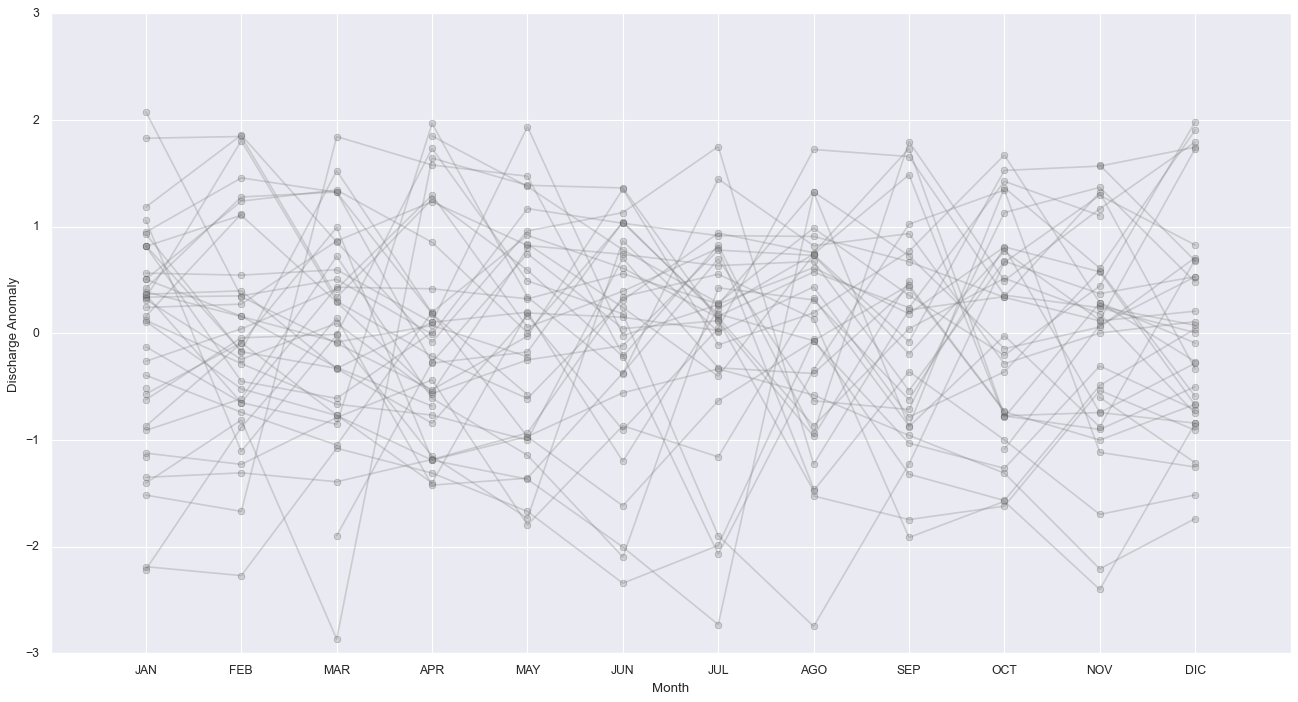

In [24]:
ax = MONTHLY_ANOMALY.plot(kind="line",style = 'o-',color='gray',legend=None,figsize=(20, 10),alpha=0.3)
ax.set_xlim(0,13)
ax.set_ylim(-3,3)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax.set_xlabel('Month');
ax.set_ylabel('Discharge Anomaly');

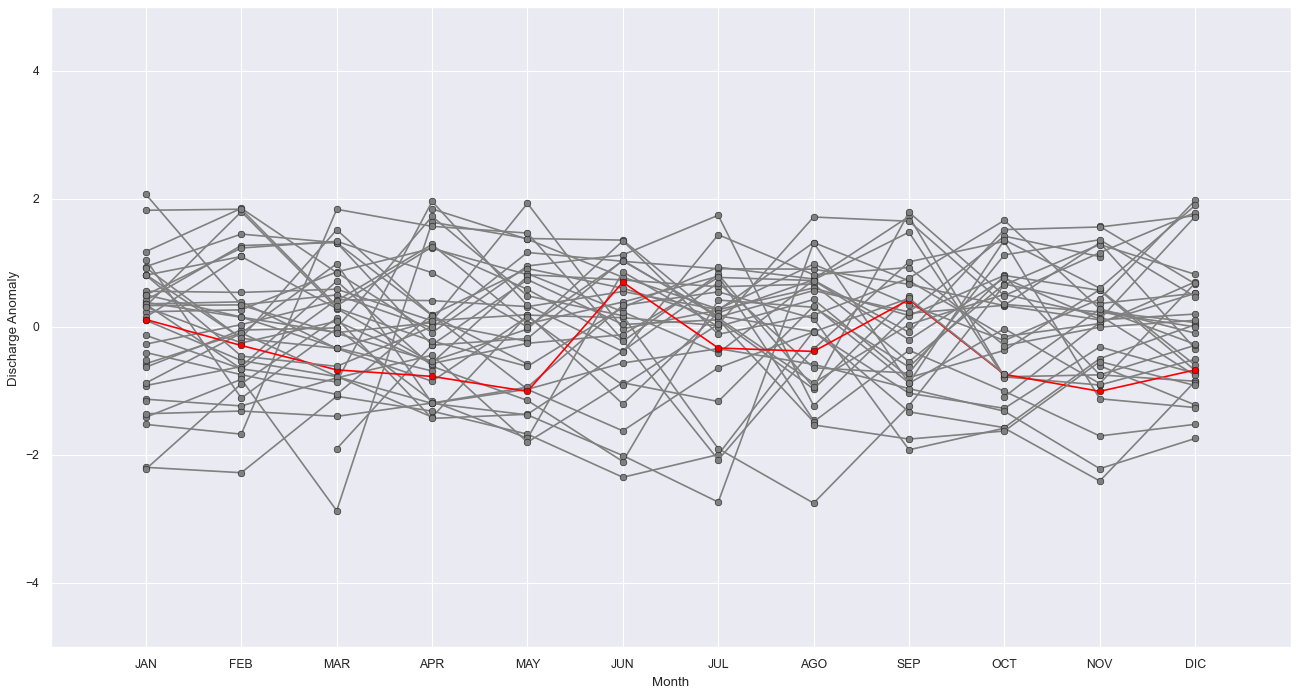

In [25]:
color_dict = {2020:'red'}

ax4 = MONTHLY_ANOMALY.plot(color=[color_dict.get(x,'gray') for x in MONTHLY_ANOMALY.columns],legend=None,kind="line",style = 'o-',figsize=(20, 10))
ax4.set_xlim(0,13)
ax4.set_ylim(-5,5)
ax4.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax4.set_xlabel('Month');
ax4.set_ylabel('Discharge Anomaly');


## Hydrological Analogues method

We create a function called add_month that add the number of months based on an input date. This will be used in the Jack-Knife Validation

In [26]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

We import the monthly river flow anomalies from 1980 to 2022 

In [27]:
ANOMALY_ANALOGUES = MONTHLY_ANOMALY[range(1980,2024,1)]
QLOG_ANALOGUES = LOG_DISCHARGE_MONTHLY_PIVOT[range(1980,2024,1)]
HTML(ANOMALY_ANALOGUES.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.242551,0.564343,0.339446,0.389118,1.184007,-0.125607,-0.568066,-0.909817,0.821847,-2.187567,-0.622136,-0.514734,-0.393814,0.160576,0.506662,-0.261938,NaN,NaN,NaN,0.949184,NaN,0.422258,NaN,0.815466,NaN,-1.403895,1.058340,-1.516886,-0.869631,-2.214302,0.332572,-1.350078,-1.123166,0.930781,1.829124,0.110915,0.360412,0.366534,0.316626,2.076678,0.121447,0.506353,0.814821,-1.158424
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,-0.041997,NaN,-0.739230,1.118936,0.160347,0.042501,NaN,NaN,NaN,1.457249,NaN,1.278344,NaN,1.106835,NaN,-0.812486,-1.106044,-1.668932,-0.091054,-0.882367,1.806216,-1.307800,-1.228274,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,-0.008945,NaN,-1.047954,NaN,-0.320880,0.416617,NaN,NaN,NaN,1.322112,NaN,1.324708,NaN,0.293664,-1.897364,-2.865380,-0.017256,1.844584,0.992752,0.141781,0.301777,-1.391326,-0.789446,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,1.733106,NaN,0.197988,NaN,-0.681955,1.295452,NaN,NaN,NaN,0.183345,NaN,-0.279005,1.850280,-0.554534,-0.272043,1.642698,-1.151650,1.578077,-1.188053,-1.423151,-0.215108,-1.182696,-0.436021,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,0.491859,NaN,0.918528,0.838282,NaN,0.056555,NaN,NaN,NaN,-0.574069,NaN,-0.174264,1.376587,0.796379,0.745970,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,0.181999,NaN,0.611383,0.242424,NaN,0.395192,NaN,NaN,NaN,NaN,NaN,1.047839,0.782982,NaN,0.044578,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,-1.895827,NaN,0.147208,-0.401491,NaN,0.796778,NaN,NaN,NaN,NaN,NaN,0.161235,0.284783,NaN,0.118354,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,-2.746924,NaN,-0.867297,0.737369,NaN,-1.455140,NaN,NaN,NaN,NaN,NaN,0.574385,0.986016,NaN,-0.964095,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,-1.224236,NaN,0.043067,-0.077626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240396,0.356304,NaN,0.490827,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,0.664472,NaN,0.516144,1.527402,NaN,NaN,NaN,NaN,-1.087165,-0.774208,NaN,1.425341,-0.206289,NaN,NaN,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


In [28]:
ANOMALY_ANALOGUE_TS = pd.melt(ANOMALY_ANALOGUES.reset_index(), id_vars='index',var_name=['Year'],ignore_index = True)
ANOMALY_ANALOGUE_TS.columns = ['Month','Year','Anomaly_Qlog']
HTML(ANOMALY_ANALOGUE_TS.head(6).to_html())

,Month,Year,Anomaly_Qlog
0,1,1980,0.242551
1,2,1980,0.273627
2,3,1980,0.865486
3,4,1980,1.233892
4,5,1980,0.823457
5,6,1980,0.739797


In [29]:
QLOG_ANALOGUE_TS = pd.melt(QLOG_ANALOGUES.reset_index(), id_vars='Month',var_name=['Year'],ignore_index = True)
QLOG_ANALOGUE_TS.columns = ['Month','Year','Qlog']
HTML(QLOG_ANALOGUE_TS.head(6).to_html())

,Month,Year,Qlog
0,1,1980,2.157115
1,2,1980,2.691706
2,3,1980,3.433779
3,4,1980,4.228206
4,5,1980,3.973884
5,6,1980,4.481231


In [30]:
HTML(ANOMALY_ANALOGUE_TS.head(6).to_html())

,Month,Year,Anomaly_Qlog
0,1,1980,0.242551
1,2,1980,0.273627
2,3,1980,0.865486
3,4,1980,1.233892
4,5,1980,0.823457
5,6,1980,0.739797


In this section, we will apply Jack Knife verification for each year and for each month of that year. The Jack Knife verification is a method that drop one year and calculate the forecast using the remaining of the years. 

In [31]:
# Select the year of analysis
YEAR_ANALYSIS = range(1980,2023,1)
MONTH_ANALYSIS = range(1,13,1)

# Create empty dataframe
ANOMALY_HINDCAST = pd.DataFrame()
HINDCAST_MONTHS = pd.DataFrame()
HINDCAST_STATS_QLOG = pd.DataFrame()
HINDCAST_STATS_ANOMALY = pd.DataFrame()
RESCALE_FORECAST =  ANOMALY_ANALOGUE_TS
SCALE_FORECAST = ANOMALY_ANALOGUE_TS

for y in YEAR_ANALYSIS:
    # extract the monthly anomalies for the corresponding year of analysis
    ANOMALY_YEAR = ANOMALY_ANALOGUES[y].to_frame()

    # From the Qlog values, drop the monthly values for the year of analysis and mantain the remaining years. This is the Qlog hindcast series
    QLOG_HINDCAST = QLOG_ANALOGUES.drop([y],axis=1)
    QLOG_HINDCAST_TS = QLOG_ANALOGUE_TS[QLOG_ANALOGUE_TS['Year'] != y]
    # From the monthly anomaly values, drop the monthly values for the year of analysis and mantain the remaining years. This is the anomaly hindcast series
    ANOMALY_HINDCAST = ANOMALY_ANALOGUES.drop([y],axis=1)
    # Calculate statistic for the hindcast Qlog serie
    HINDCAST_STATS_QLOG['mean'] = np.mean(QLOG_HINDCAST,axis=1)
    HINDCAST_STATS_QLOG['std'] = np.std(QLOG_HINDCAST,axis=1)
    # Calculate statistic for the hindcast Anomaly serie
    HINDCAST_STATS_ANOMALY['mean'] = np.mean(ANOMALY_HINDCAST,axis=1)
    HINDCAST_STATS_ANOMALY['std'] = np.std(ANOMALY_HINDCAST,axis=1)

    # for each year of analysis, we are going to iterate by each month (1 to 12)
    for m in MONTH_ANALYSIS:
        print('Dropping year:',y,"-","End-Month:",m)
        # extract from the hindcast series, all the corresponding monthly values based on the month of analysis. After this, it transpose the table  
        HINDCAST_MONTHS = ANOMALY_HINDCAST.loc[[m]].T
        # Obtain the Anomaly value for the end month (analysis)
        ANOMALY_ANALYSIS = ANOMALY_YEAR.query('index==@m')[y].item()
        # Create a datetime that consider the current year and month
        END_MONTH = datetime.date.today().replace(year=y, month=m, day=1)
        # Using the add_month function, we add n lead month for the forecast
        ONE_MONTH = add_months(END_MONTH,1)
        TWO_MONTH = add_months(END_MONTH,2)
        THREE_MONTH = add_months(END_MONTH,3)
        SIX_MONTH = add_months(END_MONTH,6)
        # Do the forecast using persistence method. 
        SCALE_FORECAST.loc[SCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'1_monthFcst'] = float(ANOMALY_ANALYSIS)
        SCALE_FORECAST.loc[SCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'2_monthFcst'] = float(ANOMALY_ANALYSIS)
        SCALE_FORECAST.loc[SCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'3_monthFcst'] = float(ANOMALY_ANALYSIS)
        SCALE_FORECAST.loc[SCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'6_monthFcst'] = float(ANOMALY_ANALYSIS)
        # re-standardised all the month of analysis from the hindcast series based on the mean and standard deviation.
        ANOMALY_RESCALE_HINDCAST = (HINDCAST_MONTHS - np.mean(HINDCAST_MONTHS,axis=0))/np.std(HINDCAST_MONTHS,axis=0)
        # Re-standardised the qlog discharge anomaly of the current month 
        ANOMALY_RESCALE_ANALYSIS = (ANOMALY_ANALYSIS - np.mean(HINDCAST_MONTHS,axis=0))/np.std(HINDCAST_MONTHS,axis=0)
        # Store the rescale forecast, mean and std (1-month)
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'1_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS)
        QLOG_MONTH = QLOG_HINDCAST_TS.query("Month == @ONE_MONTH.month")
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'std'] = float(np.std(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],28,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],50,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (2-month)
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'2_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS)
        QLOG_MONTH_02 = QLOG_HINDCAST_TS.query("Month == @TWO_MONTH.month")
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'std'] = float(np.std(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],28,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],50,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (3-month)
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'3_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS)
        QLOG_MONTH_03 = QLOG_HINDCAST_TS.query("Month == @THREE_MONTH.month")
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'std'] = float(np.std(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],28,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],50,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (6-month)
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'6_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS)
        QLOG_MONTH_06 = QLOG_HINDCAST_TS.query("Month == @SIX_MONTH.month")
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'std'] = float(np.std(QLOG_MONTH['Qlog'],axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],28,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],50,axis=0))
        RESCALE_FORECAST.loc[RESCALE_FORECAST.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH['Qlog'],72,axis=0))
        

Dropping year: 1980 - End-Month: 1
Dropping year: 1980 - End-Month: 2
Dropping year: 1980 - End-Month: 3
Dropping year: 1980 - End-Month: 4
Dropping year: 1980 - End-Month: 5
Dropping year: 1980 - End-Month: 6
Dropping year: 1980 - End-Month: 7
Dropping year: 1980 - End-Month: 8
Dropping year: 1980 - End-Month: 9
Dropping year: 1980 - End-Month: 10
Dropping year: 1980 - End-Month: 11
Dropping year: 1980 - End-Month: 12
Dropping year: 1981 - End-Month: 1
Dropping year: 1981 - End-Month: 2
Dropping year: 1981 - End-Month: 3
Dropping year: 1981 - End-Month: 4
Dropping year: 1981 - End-Month: 5
Dropping year: 1981 - End-Month: 6
Dropping year: 1981 - End-Month: 7
Dropping year: 1981 - End-Month: 8
Dropping year: 1981 - End-Month: 9
Dropping year: 1981 - End-Month: 10
Dropping year: 1981 - End-Month: 11
Dropping year: 1981 - End-Month: 12
Dropping year: 1982 - End-Month: 1
Dropping year: 1982 - End-Month: 2
Dropping year: 1982 - End-Month: 3
Dropping year: 1982 - End-Month: 4
Dropping year:

Drop columns from the variable ANOMALY_ANALOGUE_TS

In [32]:
ANOMALY_ANALOGUE_TS = ANOMALY_ANALOGUE_TS.drop(['1_monthFcst', '2_monthFcst','3_monthFcst','6_monthFcst','mean','std','low','medium','high'], axis=1)
HTML(ANOMALY_ANALOGUE_TS.tail(6).to_html(index=False))

Month,Year,Anomaly_Qlog
7,2023,NaN
8,2023,NaN
9,2023,NaN
10,2023,NaN
11,2023,NaN
12,2023,NaN


## Hydrological Analogues Method

the monthly anomalies of the most recently past months are compared with all possible historical sequences of anomalies covering the same months of the year. That is, if the recent past covers, say, the months February to July, then potential analogues are sought only in the February to July sequences of the historical record

In [33]:
# Select the end-month and year
END_YEAR = 2023
END_MONTH = 1
END_DATE = datetime.date.today().replace(year=END_YEAR, month=END_MONTH, day=1)
# Define the first date. In this case it will be 9 months before end_data 
FIRST_DATE = add_months(END_DATE,-9)

Create a column with datetime values

In [34]:
ANOMALY_ANALOGUE_TS['DATE'] = pd.to_datetime(ANOMALY_ANALOGUE_TS[['Year', 'Month']].assign(DAY=1))
HTML(ANOMALY_ANALOGUE_TS.head(6).to_html(index=False))

Month,Year,Anomaly_Qlog,DATE
1,1980,0.242551,1980-01-01
2,1980,0.273627,1980-02-01
3,1980,0.865486,1980-03-01
4,1980,1.233892,1980-04-01
5,1980,0.823457,1980-05-01
6,1980,0.739797,1980-06-01


Query in the anomaly_analogue_ts the first date and end date

In [35]:
ANOMALY_NOW = ANOMALY_ANALOGUE_TS.query('DATE > @FIRST_DATE & DATE <= @END_DATE')
HTML(ANOMALY_NOW.to_html(index=False))

Month,Year,Anomaly_Qlog,DATE
5,2022,NaN,2022-05-01
6,2022,NaN,2022-06-01
7,2022,NaN,2022-07-01
8,2022,-1.524998,2022-08-01
9,2022,-1.745873,2022-09-01
10,2022,-1.620122,2022-10-01
11,2022,-0.535129,2022-11-01
12,2022,-0.908354,2022-12-01
1,2023,-1.158424,2023-01-01


Define a Root Mean Square Error Function. This function will be used to select the analogues years

In [36]:
def rmse(predictions,targets):
    return ((predictions - targets) ** 2).mean() ** 0.5

Set the year of analysis from 1981 to 2022

In [37]:
YEAR_ANALYSIS = range(1981,2023,1)

In [38]:
# create empty database and lists
df = pd.DataFrame()
ANOMALY_HISTORICAL = pd.DataFrame()
RMSE = []
ANO = []

for y in YEAR_ANALYSIS:
    # define end month and year based on the for-loop
    END_DATE_HIST = datetime.date.today().replace(year=y, month=END_MONTH, day=1)
    # 9 months before
    FIRST_DATE_HIST = add_months(END_DATE_HIST,-9)
    # query in the anomaly time serie the first date and end_date
    ANOMALY_HISTORIC = ANOMALY_ANALOGUE_TS.query('DATE > @FIRST_DATE_HIST & DATE <= @END_DATE_HIST')
    # create a dataframe (df) for the "preditec" (analogue) and "target" (current year)
    df['predicted'] = ANOMALY_HISTORIC["Anomaly_Qlog"].values
    df['target'] = ANOMALY_NOW["Anomaly_Qlog"].values
    # if there is missing data then escape the for-loop
    if df['predicted'].isnull().values.any() == False:
        # calculate the RMSE
        RMSE_val = rmse(df['predicted'],df['target'])
        # append in the empty lists
        RMSE.append(RMSE_val)
        ANO.append(y)
        ANOMALY_HISTORICAL[y] = df['predicted']
        # print('the year ',y, 'has a RMSE of:', round(RMSE,2))
    else:
        # print('the year ',y, 'has missing data')
        continue

Reset the index and change it to month name

In [39]:
import calendar 

# ANOMALY_HISTORICAL.index = np.arange(FIRST_DATE_HIST.month + 1, END_DATE_HIST.month + 1)
ANOMALY_HISTORICAL.index = [5,6,7,8,9,10,11,12,1]
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.reset_index()
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.rename(columns={"index": "MONTH"})

ANOMALY_HISTORICAL['MONTH'] = ANOMALY_HISTORICAL['MONTH'].apply(lambda x: calendar.month_abbr[x])
HTML(ANOMALY_HISTORICAL.to_html(index=False))


MONTH,1981,1982,1983,1985,1986,1988,1989,1990,1991,1993,1994,2003,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
May,0.823457,1.937208,1.169828,0.959713,0.323464,-1.142655,-0.969359,-1.669311,0.491859,0.918528,0.838282,1.376587,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882
Jun,0.739797,-0.022238,1.031563,1.131854,0.559764,-2.096553,-1.616891,-2.342581,0.181999,0.611383,0.242424,0.782982,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191
Jul,0.634343,0.268281,0.915541,1.751074,0.275448,0.426789,-0.632508,-1.988811,-1.895827,0.147208,-0.401491,0.284783,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362
Aug,0.674806,1.325393,0.908398,-1.226501,0.615600,0.313288,-0.071836,-0.057456,-2.746924,-0.867297,0.737369,0.986016,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295
Sep,-0.536759,0.726755,0.671798,0.219607,0.183293,-0.621314,-1.029305,-1.320600,-1.224236,0.043067,-0.077626,0.356304,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745
Oct,0.675993,-0.144178,0.337564,0.344257,0.810697,0.804191,-1.265752,-1.567117,0.664472,0.516144,1.527402,-0.206289,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074
Nov,0.371782,0.058760,0.116947,1.321250,0.576710,-0.742162,-0.306612,-0.488682,1.293828,0.184266,1.567701,0.443194,-1.697598,0.589034,-1.116108,-2.208465,1.368363,-0.742535,-2.401258,0.611059,0.286742,1.166715,-0.877936,0.002463,0.239615,0.123945,0.287014,-1.000139
Dec,0.531162,0.709557,0.207455,-0.335079,-0.673853,-0.280400,-0.717159,0.041827,0.827914,-0.751122,1.745181,1.982615,-1.515294,-0.590456,-1.253367,-1.736584,0.480499,-0.841841,-0.843398,1.905575,-0.265156,1.793605,0.691449,0.109904,0.006366,1.730740,-0.091308,-0.665359
Jan,0.564343,0.339446,0.389118,-0.125607,-0.568066,0.821847,-2.187567,-0.622136,-0.514734,0.160576,0.506662,0.815466,1.058340,-1.516886,-0.869631,-2.214302,0.332572,-1.350078,-1.123166,0.930781,1.829124,0.110915,0.360412,0.366534,0.316626,2.076678,0.121447,0.506353


Create a dataframe with the list "YEAR" and "RMSE"

In [40]:
RESULTS = pd.DataFrame()
RESULTS['YEAR'] = ANO
RESULTS['RMSE'] = RMSE

Select the 5 minimum RMSE value from the dataframe

In [55]:
BEST_RMSE = RESULTS.sort_values(by=['RMSE']).head(3)
HTML(BEST_RMSE.to_html(index=False))

YEAR,RMSE
1990,0.767024
1989,0.806085
2009,1.017671


Extract the years from the ANOMALY Historical Variable

In [56]:
ANOMALY_PLOT = ANOMALY_HISTORICAL.loc[:, BEST_RMSE['YEAR']]
# ANOMALY_PLOT.index = np.arange(FIRST_DATE_HIST.month + 1, END_DATE_HIST.month + 1)
ANOMALY_PLOT.index = [5,6,7,8,9,10,11,12,1]
ANOMALY_PLOT = ANOMALY_PLOT.reset_index()
ANOMALY_PLOT = ANOMALY_PLOT.rename(columns={"index": "MONTH"})
ANOMALY_PLOT['MONTH'] = ANOMALY_PLOT['MONTH'].apply(lambda x: calendar.month_abbr[x])

Append the "REF" or "ACTUAL" date

In [57]:
ANOMALY_PLOT["REF"] = ANOMALY_NOW["Anomaly_Qlog"].values

In [58]:
HTML(ANOMALY_PLOT.to_html(index=False))

MONTH,1990,1989,2009,REF
May,-1.669311,-0.969359,-0.967503,NaN
Jun,-2.342581,-1.616891,-0.557374,NaN
Jul,-1.988811,-0.632508,-0.333168,NaN
Aug,-0.057456,-0.071836,-0.579201,-1.524998
Sep,-1.320600,-1.029305,-0.956767,-1.745873
Oct,-1.567117,-1.265752,-1.310581,-1.620122
Nov,-0.488682,-0.306612,-2.208465,-0.535129
Dec,0.041827,-0.717159,-1.736584,-0.908354
Jan,-0.622136,-2.187567,-2.214302,-1.158424


In [59]:
ANOMALY_PLOT.to_clipboard()

Generate a plot 

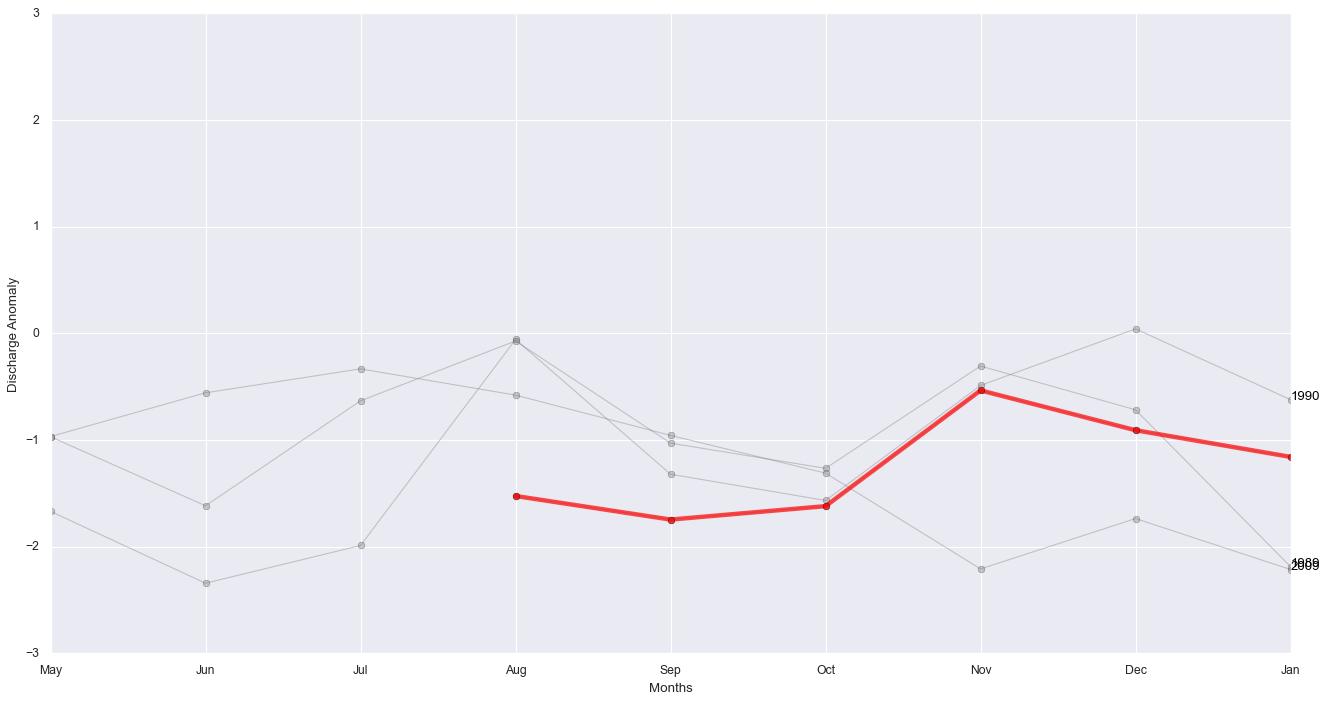

In [60]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column in ANOMALY_PLOT.drop('MONTH', axis=1):
    plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT[column], marker='o', color='grey', linewidth=1, alpha=0.4);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT['REF'], marker='o', color='red', linewidth=4, alpha=0.7);

num=0
for i in ANOMALY_PLOT.values[8][1:]:
    num+=1
    name=list(ANOMALY_PLOT)[num]
    if name != 'REF':
        plt.text(8, i, name, horizontalalignment='left', size='medium', linespacing=0.4, color='black')
        
plt.ylim(-3,3)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');



Print the most similar analogue year

In [46]:
print('A similar analogues year is:',str(BEST_RMSE['YEAR'].iloc[0]))

A similar analogues year is: 1990


Copy variable for Excel

In [47]:
# ANOMALY_PLOT.to_clipboard()

In [48]:
# ANOMALY_ANALOGUE_TS.to_clipboard()